In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [7]:
import glob
import pickle

In [8]:
glob.glob('../data/simulated/*')

['../data/simulated/hawkes_synth_data_1d.pkl',
 '../data/simulated/hawkes_synth_data_2d.pkl',
 '../data/simulated/README.md']

In [9]:
from load_synth_data import process_loaded_sequences, one_hot_embedding

## 1D process

In [10]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_1d.pkl", "rb") as f:
    loaded_hawkes_data = pickle.load(f)

In [11]:
loaded_hawkes_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [12]:
mu = loaded_hawkes_data['mu']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print(mu)
print(decay)
print(tmax)

1.0
5.0
60.0


In [13]:
times_tensor, types_tensor, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data)

## 2D process

In [10]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_2d.pkl", "rb") as f:
    loaded_hawkes_2d_data = pickle.load(f)

In [11]:
loaded_hawkes_2d_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [12]:
print(loaded_hawkes_2d_data['mu'])
print(loaded_hawkes_2d_data['alpha'])
print(loaded_hawkes_2d_data['decay'])
tmax = loaded_hawkes_2d_data['tmax']
print(f"tmax: {tmax}")

[0.7 1. ]
[[0.1  0.15]
 [0.01 0.01]]
0.01
tmax: 60.0


In [116]:
times_tensor, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_2d_data)

onehot_types = one_hot_embedding(seq_types, 3)

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= \sigma(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [129]:
from models.decayrnn import HawkesDecayRNN
from train_functions import train_decayrnn

In [130]:
hidden_size = 8
model = HawkesDecayRNN(2, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.013)

In [131]:
# define training loop
train_size = int(0.6*times_tensor.size(1))
EPOCHS = 50
BATCH_SIZE = 32
print("Train size %d" % train_size)

Train size 1200


In [132]:
train_times_tensor = times_tensor[:, :train_size]
train_onehot_types = onehot_types[:, :train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_onehot_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train event times shape torch.Size([167, 1200])
Train event types shape torch.Size([167, 1200, 3])
Train seq lengths shape torch.Size([1200])


In [ ]:
train_decayrnn(model, optimizer, train_times_tensor, train_onehot_types, train_seq_lengths, tmax,
               BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 32
Number of epochs 50


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
epochs_range = list(range(1, EPOCHS+1))
ax.plot(epochs_range, loss_hist, color='red',
         linewidth=.7, marker='.', markersize=6)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

the following tensor has shape 2 * 2 * 3, and on the third dim, we have three values and only one is right (1 instead of zero)

In [59]:
from models.decayrnn import generate_sequence

In [72]:
gen_event_times, gen_event_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)

In [61]:
# Build a statistic for the no. of events
gen_seq_lengths = []
n_gen_seq = 500 # number of generated sequences
for i in range(n_gen_seq):
    (gen_event_times, gen_event_types,
     gen_event_intens, gen_event_decay) = generate_sequence(model, tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)

In [62]:
MODEL_NAME = "Decay-RNN"

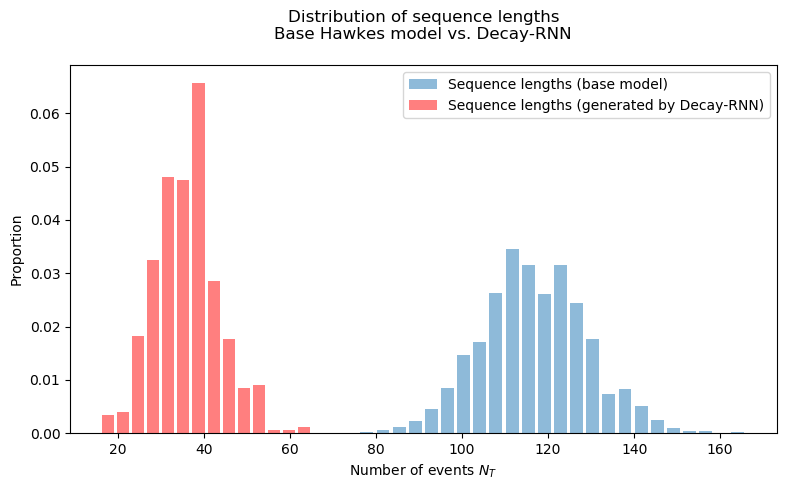

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
_ = ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
_ = ax.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            rwidth=0.8, alpha=0.5, color='red', density=True)
ax.legend()
ax.set_ylabel('Proportion')
ax.set_xlabel('Number of events $N_T$')
ax.set_title("""Distribution of sequence lengths
Base Hawkes model vs. {:}
""".format(MODEL_NAME))
fig.tight_layout()

In [64]:
RESULT_BASEDIR = "../results"
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}.{:}.pdf".format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME))

The number of events does not fit.

In [66]:
def plot_events_and_intensity(event_times: torch.Tensor, seq_types: torch.Tensor,
                              hidden_states: torch.Tensor, event_decay: torch.Tensor):
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, dpi=120,
                                   gridspec_kw = {'height_ratios':[3, 0.3]},
                                   figsize=(10,6))
    time_arr = np.linspace(0, tmax, 1000)
    n_events = event_times.shape[0] - 1
    max_intens = max(e.max() for e in hidden_states)
    min_intens = min(e.min() for e in hidden_states)
    y_intens = []
    curr_index = 0
    for ti in time_arr:
        if curr_index < len(hidden_states)-1 and ti > event_times[curr_index+1]:
            curr_index += 1
        hi = hidden_states[curr_index]
        li = model.intensity_activ(model.intensity_layer(hi)).detach().numpy()
        dec = event_decay[curr_index].numpy()
        t_incr = ti - event_times[curr_index]  # >= 0 by construction
        y_intens.append(li*np.exp(-dec*t_incr))
    event_intens = [model.intensity_activ(model.intensity_layer(h)).item()
                    for h in hidden_states]
    ax0.scatter(event_times[1:], event_intens,
                facecolor='k',
                s=6, alpha=0.7)
    ax0.set_ylabel("Event intensities $\lambda_t$")
    ax0.plot(time_arr, y_intens, color='r',
             linewidth=.7, linestyle='--')
    ax1.scatter(event_times[1:], np.random.rand(n_events),
                alpha=0.4, s=16)
    ax1.set_ylim((-0.3,1.3))
    ax1.set_xlabel("Time $t$")

ValueError: only one element tensors can be converted to Python scalars

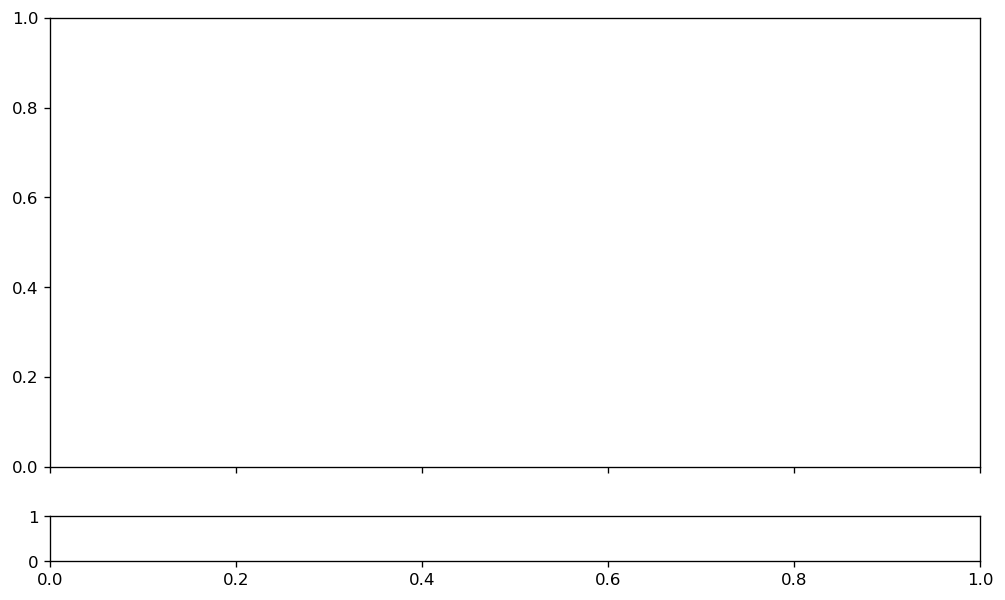

In [74]:
gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)
plot_events_and_intensity(gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay)

In [91]:
cmap.__call__([0, 50, 200])

array([[0.96862745, 0.98431373, 1.        , 1.        ],
       [0.81707036, 0.88589004, 0.95078816, 1.        ],
       [0.10249904, 0.40868897, 0.6828912 , 1.        ]])

In [97]:
cmap.colorbar_extend

False

In [73]:
gen_evt_types

tensor([3., 2., 1., 2., 1., 1., 2., 2., 0., 0., 0., 0., 1., 0., 0., 2., 1., 1.,
        2., 0., 0., 0., 1., 2., 1., 0., 0., 2.])